In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
import sklearn
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,10)
legend_fontsize = 16

# Классификация

## Сгенерируем данные

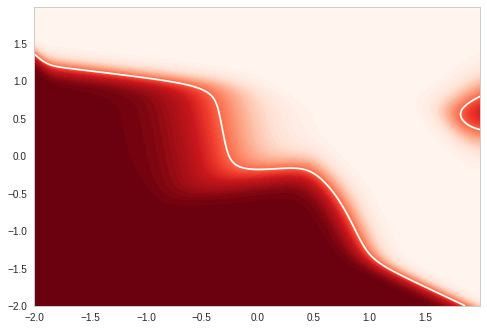

In [8]:

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

centers_1 = np.random.multivariate_normal([-1,-1], 1.5*np.identity(2), size=10)
centers_2 = np.random.multivariate_normal([1,1], 1.5*np.identity(2), size=10)

def mn(x, c, mat):
	return sp.stats.multivariate_normal.pdf(x, mean=c, cov=mat)

def sample_point(centers, cov=.1 * np.identity(2)):
	i = np.random.randint(len(centers))
	return np.random.multivariate_normal(centers[i], cov)

def my_density(pos, centers):
	return np.sum([ mn(pos, c, .1 * np.identity(2)) for c in centers ], axis=0) / float(len(centers))

def my_density_ratio(pos, centers_1, centers_2):
	return my_density(pos, centers_1) / (my_density(pos, centers_1) + my_density(pos, centers_2))

z_1 = my_density(pos, centers_1)
z_2 = my_density(pos, centers_2)
z = my_density_ratio(pos, centers_1, centers_2)

num_levels = 50
plt.contourf(x, y, z, num_levels, cmap='Reds', ls=None, transparent=True)
plt.contour(x, y, z, levels=[0.5], color='black')
plt.show()

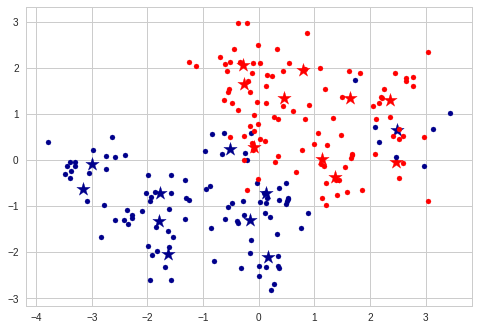

In [9]:
points_1 = np.array([ sample_point(centers_1, cov=.2 * np.identity(2)) for _ in range(100) ])
points_2 = np.array([ sample_point(centers_2, cov=.2 * np.identity(2)) for _ in range(100) ])

def plot_twopoints(ax, d1, d2, sizes=[15,25], markers=[ 'o', '*' ], colors=['0.3', '0.3']):
	ax.scatter(d1[:,0], d1[:,1], s=sizes[0], marker=markers[0], color=colors[0])
	ax.scatter(d2[:,0], d2[:,1], s=sizes[1], marker=markers[1], color=colors[1])

fig, ax = plt.subplots()
plot_twopoints(ax, centers_1, centers_2, sizes=[200,200], markers=['*', '*'], colors=['darkblue', 'r'])
plot_twopoints(ax, points_1, points_2, sizes=[25,25], markers=['o', 'o'], colors=['darkblue', 'r'])
plt.show()

In [10]:
## Рисуем результаты модели
def plot_model_results(m, c1=centers_1, c2=centers_2, p1=points_1, p2=points_2):
    xdata = np.array([ x for x in points_1 + points_2 ])
    x_min, x_max = min(xdata[:,0]), max(xdata[:,0])
    y_min, y_max = min(xdata[:,1]), max(xdata[:,1])
    x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pos_lin = pos.reshape(pos.shape[0] * pos.shape[1], 2)
    pred_lin = m.decision_function(pos_lin)
    pred = pred_lin.reshape(pos.shape[0], pos.shape[1])

    fig, ax = plt.subplots()
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.contourf(x, y, pred, num_levels, cmap='Reds', alpha=0.5, ls=None)
    ax.contour(x, y, pred, levels=[0.5])
#     ax.plot(np.arange(x_min, x_max, .01), (-m.intercept_ - m.coef_[0][0]*np.arange(x_min, x_max, .01)) / m.coef_[0][1], color='black')
    plot_twopoints(ax, centers_1, centers_2, sizes=[400,400], markers=['*', '*'], colors=['darkblue', 'r'])
    plot_twopoints(ax, points_1, points_2, sizes=[50,50], markers=['o', 'o'], colors=['darkblue', 'r'])
    plt.show()
    

In [11]:
x_and_y = [ (p, 0) for p in points_1 ] + [ (p,1) for p in points_2 ]
np.random.shuffle(x_and_y)

data_X = np.array([x[0] for x in x_and_y])
data_y = np.array([x[1] for x in x_and_y])
x_min, x_max = min(data_X[:,0]), max(data_X[:,0])
y_min, y_max = min(data_X[:,1]), max(data_X[:,1])

from sklearn import linear_model
import sklearn

## SVM

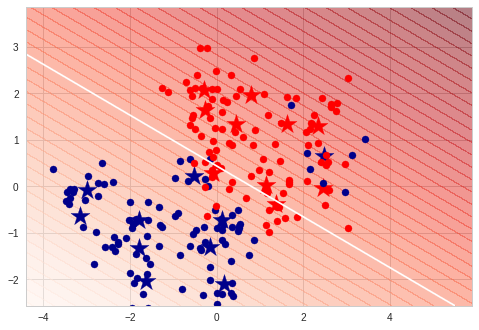

In [12]:
import sklearn
m = sklearn.svm.SVC(kernel='linear', C=0.1)
m.fit(data_X, data_y)
plot_model_results(m)

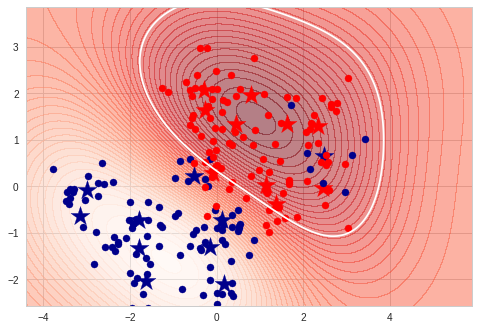

In [15]:
m = sklearn.svm.SVC(kernel='rbf', gamma=0.2, C=0.1)
m.fit(data_X, data_y)
plot_model_results(m)

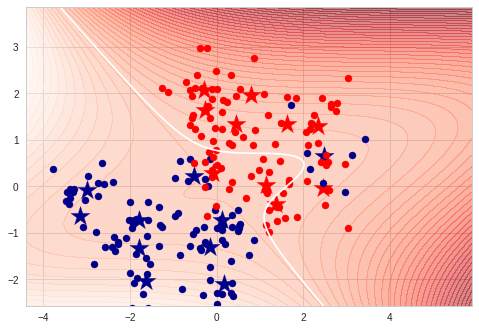

In [17]:
m = sklearn.svm.SVC(kernel='poly', degree=3, C=01.00020)
m.fit(data_X, data_y)
plot_model_results(m)

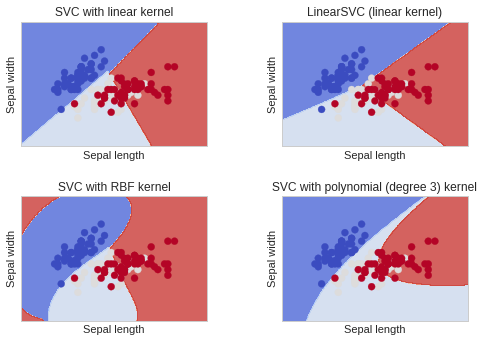

In [18]:
from sklearn import svm, datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
h = .02 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

In [19]:
from sklearn import preprocessing

X = iris.data
y = iris.target

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("Наилучшие параметры: %s, score = %0.2f"
      % (grid.best_params_, grid.best_score_))

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = sklearn.svm.SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

Наилучшие параметры: {'C': 1.0, 'gamma': 0.10000000000000001}, score = 0.97


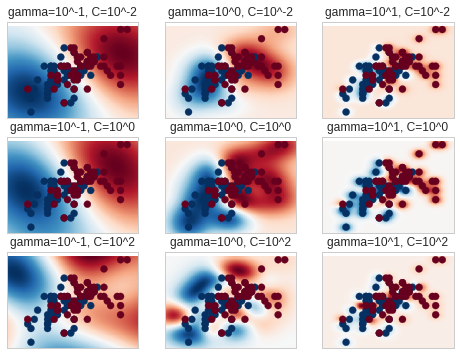

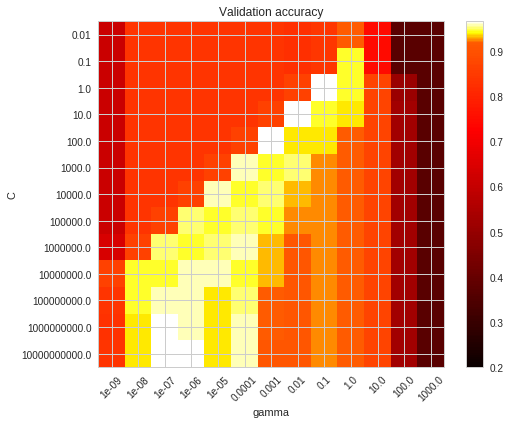

In [21]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
# create a mesh to plot in
h = .02 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel','Validation accuracy']
plt.show()